<center> <font size=6>Replication - Pastor & Stambaugh (2003)</font> <br>

<center> Monthly Aggregated Liquidity & Innovation of Liquidity & Liquidity Factor from 2000 to end of 2023 <br>

<br>
<hr style="border:0.02in solid gray"></hr>
<br>

## Data Preparation

In [1]:
import time
starttime = time.time()

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

Firstly, let's load the daily data set to construct our variables

In [3]:
df = pd.read_csv('crsp_daily.csv', delimiter=',', index_col='date', low_memory=False)
df.index = pd.to_datetime(df.index)
df

,PERMNO,SHRCD,PRC,VOL,RET,vwretd
date,,,,,,
2000-01-03,10001,11.0,8.56250,1721.0,0.007353,-0.006803
2000-01-04,10001,11.0,8.43750,1080.0,-0.014599,-0.039652
2000-01-05,10001,11.0,8.56250,1711.0,0.014815,-0.000935
2000-01-06,10001,11.0,8.50000,580.0,-0.007299,-0.007391
2000-01-07,10001,11.0,8.43750,1406.0,-0.007353,0.032516
...,...,...,...,...,...,...
2023-12-22,93436,11.0,252.53999,93148541.0,-0.007701,0.002440
2023-12-26,93436,11.0,256.60999,86700724.0,0.016116,0.005218
2023-12-27,93436,11.0,261.44000,106250779.0,0.018822,0.001995


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44915489 entries, 2000-01-03 to 2023-12-29
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   PERMNO  int64  
 1   SHRCD   float64
 2   PRC     float64
 3   VOL     float64
 4   RET     object 
 5   vwretd  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 2.3+ GB


Here the RET column should be in type float, so we exclude the abnormal values and convert the column to float.

In [5]:
df['RET'] = df['RET'].apply(lambda x: np.nan if x in ['A', 'B', 'C', 'D', 'E', '0'] else x).astype(float)

Next, we only keep common stock (share code 10 and 11) as in the original paper, exclude days with no volume and create column for dollar volume value and excess returns, where excess returns equal daily returns minus market value weighted returns.

In [6]:
# Keep common stock
df_p1 = df[df['SHRCD'].isin([10,11])]

# Ignore days with no volume
df_p1['VOL'][df_p1['VOL']<=0] = np.nan
df_p1['RET'][df_p1['RET']<-1] = np.nan

# Construct volume (in USD) column
df_p1['Volume'] = df_p1['VOL'] * abs(df_p1['PRC']) / 1000000

# Construct excess returns
df_p1['retx'] = df_p1['RET'] - df_p1['vwretd']

Now we are going to exclude stocks from Nasdaq, by removing stocks with exchange code 3,33 and 0 as the authors did. We form the monthly exchange code dataframe from CRSP monthly file, then resample to create annual exchange code dataframe, shift the whole dataframe to one period ahead then replace values 3, 33 and 0 by `np.nan`.

In [7]:
data_m = pd.read_csv('crsp_monthly.csv', index_col='date')
data_m.index = pd.to_datetime(data_m.index)
data_m

,PERMNO,EXCHCD,PRC,SHROUT
date,,,,
1999-12-31,10001,3.0,-8.50000,2450.0
2000-01-31,10001,3.0,8.12500,2450.0
2000-02-29,10001,3.0,8.25000,2450.0
2000-03-31,10001,3.0,-8.00000,2464.0
2000-04-28,10001,3.0,-8.09375,2464.0
...,...,...,...,...
2023-08-31,93436,3.0,258.07999,3173994.0
2023-09-29,93436,3.0,250.22000,3179000.0
2023-10-31,93436,3.0,200.84000,3178921.0


In [8]:
# Create monthly exchange code dataframe
exch_code = data_m.pivot_table(index=data_m.index, columns='PERMNO', values='EXCHCD', aggfunc='first')
exch_code = exch_code[exch_code.columns.intersection(df_p1['PERMNO'].unique())]

# Create lagged annual exchange code dataframe, exclude code 3, 33 and 0
exch_code_lag = exch_code.shift().resample('Y').last()
exch_code_filt = exch_code_lag.where(~exch_code_lag.isin([3,33,0]), np.nan)
exch_code_filt = exch_code_filt.resample('D').bfill()

# Drop columns with no information
nan_columns = exch_code_filt.columns[exch_code_filt.isna().all()]
exch_code_filt.drop(columns=nan_columns, inplace=True)
exch_code_filt.head()

PERMNO,10001,10028,10042,10051,10066,10085,10092,10104,10108,10119,...,93384,93387,93398,93405,93418,93420,93422,93423,93426,93429
date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01,NaN,NaN,2.0,1.0,2.0,1.0,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02,NaN,NaN,2.0,1.0,2.0,1.0,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,NaN,NaN,2.0,1.0,2.0,1.0,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,NaN,2.0,1.0,2.0,1.0,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now let's form (lagged) daily (excess) returns and signed dollar volume dataframes, and replace values of a whole year by `np.nan` where the lagged exchange code is `np.nan`.

In [9]:
def df_creation(value_name, compare_df):
    '''
    Function to return dataframe pivoted from df_p1
    
    '''
    dataframe = df_p1.pivot_table(index=df_p1.index, columns='PERMNO', values=value_name, aggfunc='first')
    dataframe = dataframe[dataframe.columns.intersection(compare_df.columns)]
    dataframe = dataframe.where(~pd.isna(compare_df), np.nan)
    
    nan_columns = dataframe.columns[dataframe.isna().all()]
    dataframe.drop(columns=nan_columns, inplace=True)

    return dataframe

In [10]:
ret_df = df_creation('RET', exch_code_filt)
vw_mret = df_creation('vwretd', ret_df)
vol_df = df_creation('Volume', ret_df)

retx_df = ret_df - vw_mret
ret_lag = ret_df.shift()
retx_lag = retx_df.shift()

vol_lag = np.sign(retx_lag) * vol_df.shift()

## Part I - Monthly Aggregate Liquidity

Now we move to the first part of the replication, which is to compute monthly aggregated liquidity, or the gamma in equation (1) of the original paper:

$$
r^{e}_{i,d+1,t} = \theta_{i,t} + \phi_{i,t} r_{i,d,t} + \gamma_{i,t} sign(r^{e}_{i,d,t}) v_{i,d,t} + \epsilon_{i,d+1,t}
$$

where $r^{e}_{i,d+1,t}$, $r_{i,d,t}$, $sign(r^{e}_{i,d,t}) v_{i,d,t}$ are respectively our `retx_df`,`ret_lag` and `vol_lag` dataframes. We also exclude months and stocks with not more than 15 observations. Here we note that in *September 2001* there was the terrorist attack in the US, thus not enough trading activity (i.e less than 15 observations this month for all stocks). Therefore, we relax the observation constraint for this month to more than 10 observations, as in Pontiff and Singla (2019).

In [11]:
date_index = pd.date_range(start='2000-01-01', end='2023-12-31', freq='D')

# Extract the monthly first and last days
monthly_first_days = date_index[date_index.is_month_start]
monthly_last_days = date_index[date_index.is_month_end]

list_gamma = []

for start_day, end_day in zip(monthly_first_days, monthly_last_days):
    
    # Get monthly regression variables
    stock_gamma = []
    
    ret_reg = ret_lag[start_day:end_day]
    vol_reg = vol_lag[start_day:end_day]
    retx_reg = retx_df[start_day:end_day]
    
    for stock in retx_reg.columns:
        
        reg_var = pd.concat([ret_reg[stock],vol_reg[stock],retx_reg[stock]],
                            axis=1, keys=['ret_reg','vol_reg','retx_reg']).dropna(axis=0,how='any')
        
        # Only count month and stock where there are more than 15 observations, except for Sep 2001
        if start_day.strftime('%Y-%m') == '2001-09':
            if len(reg_var) > 10:
                X1 = reg_var[['ret_reg','vol_reg']].values.reshape(-1,2)
                y1 = reg_var['retx_reg'].values
                model = sm.OLS(y1, sm.add_constant(X1)).fit()
                gamma = model.params[2]
            else:
                gamma = np.nan
        else:
            if len(reg_var) > 15:
                X1 = reg_var[['ret_reg','vol_reg']].values.reshape(-1,2)
                y1 = reg_var['retx_reg'].values
                model = sm.OLS(y1, sm.add_constant(X1)).fit()
                gamma = model.params[2]
            else:
                gamma = np.nan
        
        stock_gamma.append(gamma)
    
    list_gamma.append(stock_gamma)

In the next step, we use monthly prices from the monthly data set and shift it 1 period forward and put the price restrictions as Pastor and Stambaugh did (we exclude a monthly stock if its price in the end of previous month is smaller than 5 or larger than 1000 dollars).

In [12]:
# Pivot lagged monthly price from monthly data
price_m = data_m.pivot_table(index=data_m.index, columns='PERMNO', values='PRC', aggfunc='first')
price_m = price_m[price_m.columns.intersection(retx_reg.columns)]
price_mlag = price_m.shift()
price_mlag.drop(price_mlag.index[0], inplace=True)

# Filter out stocks if lagged month prices are < 5 or > 1000
price_filtered = price_mlag.mask((abs(price_mlag) < 5) | (abs(price_mlag) > 1000), np.nan)
price_filtered.index = price_filtered.index.strftime('%Y-%m')

With all the restrictions met (only share code 10 & 11, exclude exchange code 3, 33 and 0, include only months with more than 15 observations and lagged monthly prices in range [5,1000]), we can now create dataframe for monthly stock level gamma and the monthly aggregate gamma, which is:
$$
\hat{\gamma_{t}} = \frac{1}{N} \sum_{i=1}^{N} \hat{\gamma_{i,t}}
$$
where N is the number of stocks which are not `np.nan` in our dataframe.

In [13]:
# Monthly stock level gamma
gamma_df = pd.DataFrame(list_gamma, index=price_filtered.index, columns=retx_reg.columns)
gamma_df = gamma_df.where(~pd.isna(price_filtered), np.nan)

# Mean monthly aggregated gamma
agg_gamma = gamma_df.mean(axis=1, skipna=True)
agg_gamma

date
2000-01   -0.001573
2000-02   -0.001195
2000-03    0.000514
2000-04   -0.006932
2000-05    0.002122
             ...   
2023-08   -0.000293
2023-09   -0.000813
2023-10    0.002028
2023-11    0.000308
2023-12   -0.001281
Length: 288, dtype: float64

Counting the number of stocks for each month, our `N` is in the range [1065,1858], which is comparable to Pastor and Stambaugh (2003).

In [14]:
num_stock = gamma_df.count(axis=1)
num_stock.describe()

count     288.000000
mean     1378.430556
std       164.154561
min      1065.000000
25%      1257.500000
50%      1320.500000
75%      1557.250000
max      1858.000000
dtype: float64

Next, we need our scaling factor `mt/m1`, where $m_{t}$ is the total market value in the end of month `t-1` of stocks that are not `null` in our dataframe in month `t`. We start by create monthly stock market capitalization value, then lag it 1 period forward. To let our final result comparable to that of Pastor and Stambaugh, we still keep August 1962 as $m_{1}$.

In [15]:
data_m['MktCap'] = abs(data_m['PRC']) * data_m['SHROUT']

MktCap = data_m.pivot_table(index=data_m.index, columns='PERMNO', values='MktCap', aggfunc='first')
MktCap = MktCap[MktCap.columns.intersection(gamma_df.columns)]
MktCap.index = MktCap.index.strftime('%Y-%m')

MktCap_lag = MktCap.shift()
MktCap_lag.drop(MktCap.index[0], inplace=True)
MktCap_lag.head()

PERMNO,10001,10028,10042,10051,10066,10085,10092,10104,10108,10119,...,93384,93387,93398,93405,93418,93420,93422,93423,93426,93429
date,,,,,,,,,,,,,,,,,,,,,
2000-01,20825.00,26550.000,14530.3125,190840.0,70645.00,490142.250,331996.000,1.595402e+08,3.045629e+06,1676363.625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02,19906.25,19912.500,11624.2500,85878.0,56516.00,458239.500,274193.125,1.422337e+08,3.718873e+06,1622112.375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03,20212.50,26550.000,20342.4375,90649.0,58040.00,406035.000,333478.125,2.107519e+08,3.847110e+06,1475634.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04,19712.00,23672.250,13077.0000,100191.0,61667.50,307426.500,280121.625,2.215733e+08,4.840947e+06,1866243.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05,19943.00,32126.625,15256.5000,94550.0,38088.75,203109.375,273475.125,2.268953e+08,4.536708e+06,1866987.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Our $m_{t}$ can be calculated as specified above, and we let $m_{1}$ equal to \$300005700 as in Pontiff and Singla (2019). We then multiply with aggregated gammas to construct scaled series of monthly aggregated liquidity.

In [16]:
mt = MktCap_lag.where(~pd.isna(gamma_df), np.nan).sum(axis=1, skipna=True)
mt_1 = mt / 300005700

agg_gamma_scaled = agg_gamma * mt_1
agg_gamma_scaled.describe()

count    288.000000
mean      -0.023971
std        0.066112
min       -0.296405
25%       -0.053051
50%       -0.018679
75%        0.016370
max        0.144627
dtype: float64

Let's compare to the results of Pastor and Stambaugh, published on the website and for the same time range.

In [17]:
PS = pd.read_csv('PSdata.csv', index_col=[0])
agg_gamma_PS = PS['PS_LEVEL']
agg_gamma_PS.describe()

count    288.000000
mean      -0.023681
std        0.068562
min       -0.308157
25%       -0.053117
50%       -0.019156
75%        0.016259
max        0.163407
Name: PS_LEVEL, dtype: float64

In [18]:
correlation_matrix = np.corrcoef(agg_gamma_scaled.values, agg_gamma_PS.values)
correlation_matrix

array([[1.      , 0.966168],
       [0.966168, 1.      ]])

We can see that our result is highly correlated to that of Pastor and Stambaugh statistically. Now we can plot these two series together to better see results and comparison.

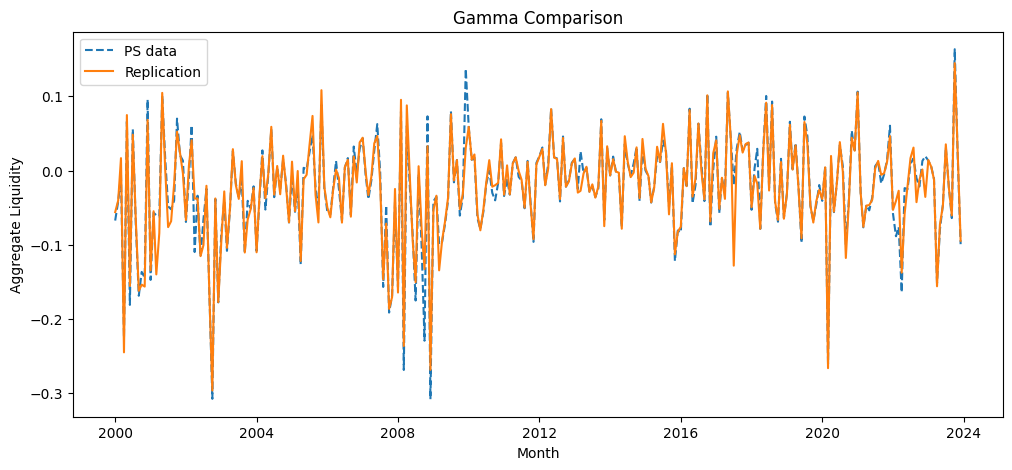

In [19]:
plt.figure(figsize=(12,5))
plt.plot(pd.to_datetime(MktCap_lag.index), agg_gamma_PS, label='PS data', linestyle='--')
plt.plot(pd.to_datetime(MktCap_lag.index), agg_gamma_scaled, label='Replication')

plt.xlabel('Month')
plt.ylabel('Aggregate Liquidity')
plt.title('Gamma Comparison')
plt.legend()
plt.show()

## Part II - Liquidity Innovation

In this part, we are going to calculate the innovation of monthly liquidity by the regression equation (7):
$$
\Delta \hat{\gamma}_{t} = a + b \Delta \hat{\gamma}_{t-1} + c \left(\frac{m_{t-1}}{m_{1}}\right) \hat{\gamma}_{t-1} + u_{t}
$$

In [20]:
gamma_eq6 = mt_1 * (gamma_df - gamma_df.shift()).mean(axis=1, skipna=True)

# Dependent variable
diff_gamma = gamma_eq6.values[2:]

# Independent variables
diff_gamma_lag = gamma_eq6.values[1:-1]
gamma_lag = (mt_1[1:-1] * agg_gamma.shift().values[1:-1]).values

X7 = np.column_stack((diff_gamma_lag, gamma_lag))

The innovation in liquidity, $L_{t}$ is then calculated as the fitted residual, arbitrarily divided by 100.

In [21]:
model2 = sm.OLS(diff_gamma, sm.add_constant(X7)).fit()
Lt = model2.resid / 100

Lt_PS = PS['PS_INNOV'].values[2:] / 100

Again, we plot our results along with Pastor and Stambaugh's for better comparison.

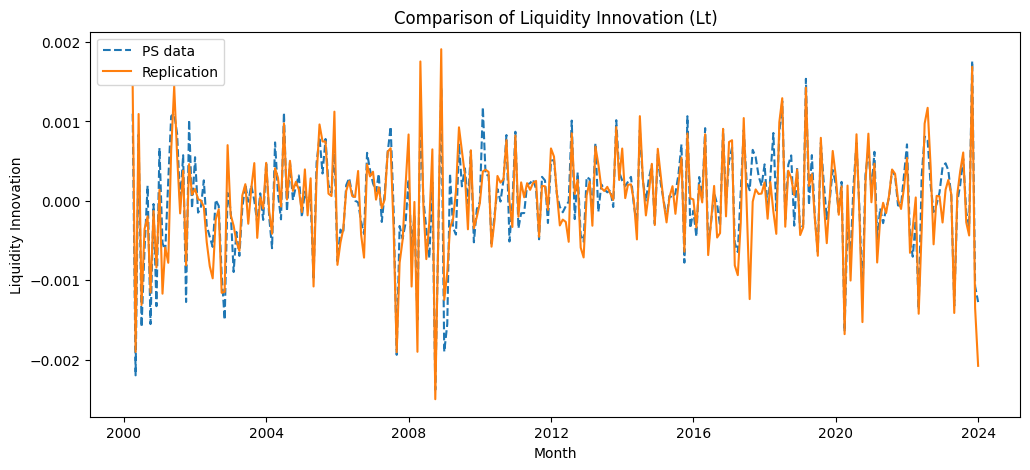

In [22]:
months = pd.date_range(start='2000-03-01', end='2023-12-31', freq='M')
plt.figure(figsize=(12,5))
plt.plot(pd.to_datetime(months), Lt_PS, label='PS data', linestyle='--')
plt.plot(pd.to_datetime(months), Lt, label='Replication')
plt.xlabel('Month')
plt.ylabel('Liquidity Innovation')
plt.title('Comparison of Liquidity Innovation (Lt)')
plt.legend()
plt.show()

## Part III - Factor Exposure and Stock expected returns

<span style="color: red;">***Note that in this part, my replication is different from the actual process of Pastor and Stambaugh due to limitation in computaional power.***</span>

First, we run the regression of each stock's monthly excess returns on the liquidity innovation and Fama-French 3 factors, as Pastor and Stambaugh did in their equation (9):

$$
r_{i,t} = \beta^{0}_{i} + \beta^{L}_{i} L_{t} + \beta^{M}_{i} MKT_{t} + \beta^{S}_{i} SMB_{t} + \beta^{H}_{i} HML_{t} + \epsilon_{i,t}
$$

In [23]:
# Load FF 3 factors data
FF3 = pd.read_csv('F-F_Research_Data_Factors.csv', index_col=[0])
FF3 = FF3.loc['200003':'202312']
RF = FF3['RF'] / 100
FF3 = FF3[['Mkt-RF','SMB','HML']] / 100

# Stock monthly excess returns
retx_m = ret_df.resample('M').last()
retx_m.index = retx_m.index.strftime('%Y-%m')
retx_m = retx_m.loc['2000-03':]
retx_m = retx_m.sub(RF.values, axis=0)

In [24]:
month_betaL = []

# Calculate historical beta every December
timerange = np.arange(70,287,12)

for i in timerange:
    
    # Reestimate Liquidity Innovation to avoid look-ahead bias
    Lt_reg = sm.OLS(diff_gamma[i-60:i],sm.add_constant(X7[i-60:i])).fit()
    Lt_reest = Lt_reg.resid
    
    stock_betaL = []
    
    for stock in retx_m.columns:
        
        reg_data = FF3.iloc[i-60:i]
        reg_data['Lt'] = Lt_reest
        reg_data['retx'] = retx_m[stock].iloc[i-60:i].values
        reg_data = reg_data.dropna(axis=0,how='any')
        
        if len(reg_data) <= 36:
            betaL = np.nan
        else:
            y9 = reg_data['retx'].values
            X9 = sm.add_constant(reg_data[['Mkt-RF','SMB','HML','Lt']].values.reshape(-1,4))
            model3 = sm.OLS(y9, X9).fit()
            betaL = model3.params[4]
            
        stock_betaL.append(betaL)
        
    month_betaL.append(stock_betaL)

We now form the $\beta^{L}$ dataframe at monthly stock level, and rank them on a tertile ranking basis.

In [25]:
beta_index = pd.date_range(start='2005-12-31', end='2024-01-01', freq='Y')
betaL_df = pd.DataFrame(month_betaL, columns=retx_m.columns, index=pd.to_datetime(beta_index))
betaL_df.head()

PERMNO,10001,10028,10042,10051,10066,10085,10092,10104,10108,10119,...,93384,93387,93398,93405,93418,93420,93422,93423,93426,93429
2005-12-31,NaN,NaN,0.050020,0.024108,NaN,0.014008,0.078012,NaN,-0.015406,0.091517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-31,NaN,NaN,-0.151738,-0.030186,NaN,-0.006847,-0.010699,NaN,-0.030220,0.073202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-12-31,NaN,NaN,-0.221017,0.044116,NaN,0.049242,-0.011410,NaN,NaN,0.060030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-31,NaN,NaN,-0.154389,0.016030,NaN,NaN,0.158482,NaN,NaN,0.020488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-31,NaN,NaN,-0.249632,0.050082,NaN,NaN,0.236777,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
def tertile_ranks(series):
    '''
    Function to rank a series on a decile ranking basis
    
    '''
    return pd.qcut(series, q=3, labels=[1, 2, 3])

def calculate_weights(row):
    '''
    Function to calculate value weighted weighting scheme
    
    '''
    valid_values = row.dropna()
    sum_valid_values = valid_values.sum()
    weights = valid_values / sum_valid_values
    return weights

def PF_returns(weights,return_df):
    '''
    Function to compute monthly decile portfolio returns
    
    '''
    for stock in weights.columns:
        for year in weights.index:
            return_df['year'] = pd.to_datetime(return_df.index).strftime('%Y')
            return_df.loc[return_df['year'] == year, stock] = return_df.loc[return_df['year'] == year, stock] * weights.loc[year,stock]
            return_df.drop(columns='year', axis=1, inplace=True)
    return return_df

Now let's rank our stocks based on predicted historical betas, and form value-weighted tertile portfolios. Here we shift the weights forward to indicate that our portfolio returns are calculated out-of-sample with annual rebalancing.

In [28]:
# Ranking based on historical beta
ranked_stock = betaL_df.apply(tertile_ranks, axis=1).shift()
ranked_stock_m = ranked_stock.resample('M').bfill()
ranked_stock_m.index = pd.to_datetime(ranked_stock_m.index).strftime('%Y-%m')

# Monthly Market cap dataframe
MktCap.index = pd.to_datetime(MktCap.index)
MktCap_y = MktCap.resample('Y').last().loc['2005':].shift()
MktCap_m = MktCap_y.resample('M').bfill()
MktCap_m.index = pd.to_datetime(MktCap_m.index).strftime('%Y-%m')

# Value-weighted portfolios
first_rank = MktCap_m.mask(ranked_stock_m.isin([2, 3]))
third_rank = MktCap_m.mask(ranked_stock_m.isin([1, 2]))

first_weights = first_rank.apply(calculate_weights, axis=1)
first_weights = first_weights.drop(first_weights.index[0])
third_weights = third_rank.apply(calculate_weights, axis=1)
third_weights = third_weights.drop(third_weights.index[0])

# Calculate portfolio returns
retx_m = retx_m.loc['2006-01':]
first_return = first_weights * retx_m
third_return = third_weights * retx_m

Next, we calculate the difference between two value-weighted portfolios (with annual rebalancing): `third_return` with long position in stocks with highest sensitivity to liquidity risk factor, and `first_return` with short postion in stocks with lowest sensititivity to liquidity risk factor.

In [29]:
# Calculate factor returns
liq_fac_ret = third_return.sum(axis=1,skipna=True) - first_return.sum(axis=1,skipna=True)
liq_fac_ret.describe()

count    216.000000
mean       0.000314
std        0.003345
min       -0.012427
25%       -0.001067
50%        0.000430
75%        0.001839
max        0.015475
dtype: float64

We can see that on average, the (il)liquidity risk exposure does have an effect on stock's expected returns, even though the average magnitude is not too large. Also, the effect is volatile over time, making it hard to say if the stock with high sensitivity to liquidity risk always have higher expected returns than ones with low sensitivity or not.

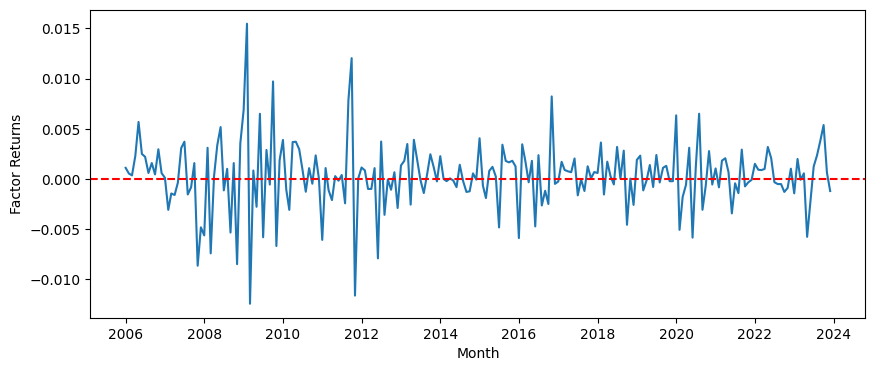

In [30]:
# Plot factor returns through time
plt.figure(figsize=(10, 4))
plt.plot(pd.to_datetime(liq_fac_ret.index), liq_fac_ret.values)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Month')
plt.ylabel('Factor Returns')
plt.show()

In [31]:
endtime = time.time()
runtime = endtime - starttime

In [32]:
print(f'Total runtime is: {runtime/60: .1f} minutes')

Total runtime is:  73.4 minutes


<br>
<hr style="border:0.02in solid gray"></hr>
<br>

# Reference:

- Pastor, Lubos and Stambaugh, Robert F., “Liquidity Risk and Expected Stock Returns”, 2003. SSRN: https://ssrn.com/abstract=279804
- Pastor, Lubos and Stambaugh, Robert F., “Liquidity Risk After 20 Years”, 2019. Chicago Booth Research Paper No. 19-13, Fama-Miller Working Paper. SSRN: https://ssrn.com/abstract=3371948
- Pontiff, Jeffrey and Singla, Rohit, “Liquidity Risk?”, 2019. SSRN: https://ssrn.com/abstract=3320011